# <center> <span style="font-family: Virgil GS, sans-serif; color:#97f788">xBooster</span> </center>
## <center> <span style="font-family: Virgil GS, sans-serif; color:navyblue">Demo notebook - Categorical features</span> </center>

In this notebook we cover three use-cases of working with categorical features:
1. Using `xBooster` with categorical features providing `category` dtypes.
2. Using `xBooster` with categorical features converted to WOE scores.
3. Using `xBooster` with categorical features after one-hot encoding.

<div class="admonition tip alert alert-warning">
<p class="first admonition-title" style="font-weight: bold;">Tip</p>
<p class="last"> For the first method, 'local' explainer method will not be available, use 'global' instead.</p>
</div>

 <span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import pandas as pd

# Fetch loan approval data
url = "https://drive.google.com/file/d/1IOgrf3TcI3V4x3jEz4X0BoCcarf8HSwM/view?usp=sharing"
url = "https://drive.google.com/uc?id=" + url.split("/")[-2]
dataset = pd.read_csv(url, index_col=False)

target = "Loan_Status"

features = [
    "Married",
    "Dependents",
    "Education",
    "Self_Employed",
    "ApplicantIncome",
    "CoapplicantIncome",
    "LoanAmount",
    "Loan_Amount_Term",
    "Credit_History",
    "Property_Area",
]

# convert loan status column from Y to 1 and N to 0
dataset[target] = dataset[target].map({"Y": 1, "N": 0})

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Using native `enable_categorical` feature</span>

This approach handles automatic handling of categorical features, provided they are assigned 'category' data type.

For this method, 'local' method of 'explainer' will not work, as the categorical splits are encoded in the model itself and cannot be retrieved back.

In [2]:
# Make a copy of the dataset
from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split

dataset_ = dataset.copy()

categorical_columns_selector = selector(dtype_include=object)  # type: ignore
categorical_features = categorical_columns_selector(dataset_[features])

numerical_columns_selector = selector(dtype_exclude=object)  # type: ignore
numerical_features = numerical_columns_selector(dataset_[features])

categorical_features.append("Credit_History")
numerical_features.remove("Credit_History")

for col in categorical_features:
    dataset_[col] = dataset_[col].astype("category")

X, y = dataset_[features], dataset[target]

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)

In [3]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.3,
    max_depth=2,
    min_child_weight=10,
    grow_policy="lossguide",
    enable_categorical=True,  # Will throw an error if not provided
    early_stopping_rounds=5,
)

# Experimental: balanced sample weights
sample_weights = np.ones(len(y.loc[ix_train]))
mask = y.loc[ix_train] == 0
sample_weights[mask] = 1.0
sample_weights[~mask] = 1.0

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)

evalset = [(X.loc[ix_train], y.loc[ix_train]), (X.loc[ix_test], y.loc[ix_test])]

# Fit the XGBoost model
xgb_model.fit(
    X.loc[ix_train], y.loc[ix_train], sample_weight=sample_weights, eval_set=evalset, verbose=False
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

Train Gini score: 66.99%
Test Gini score: 65.20%


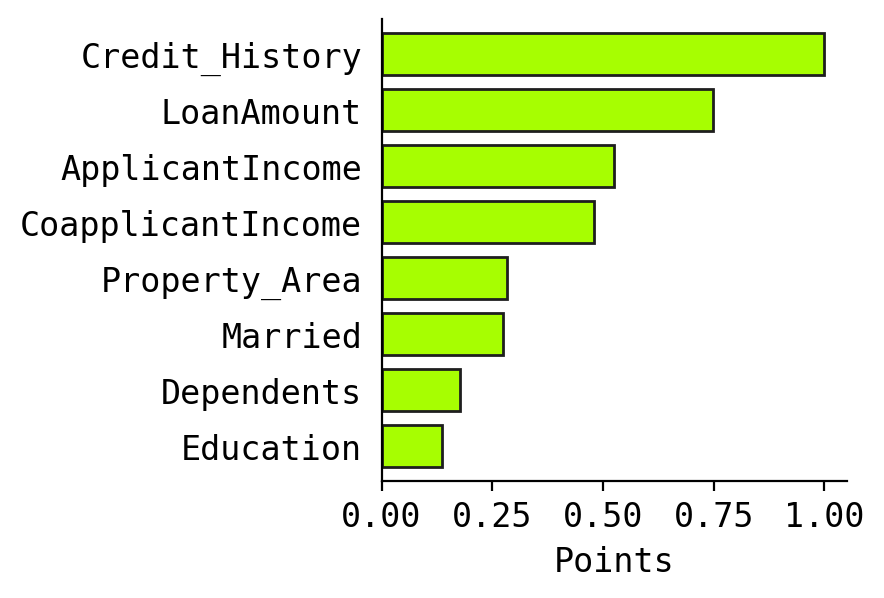

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


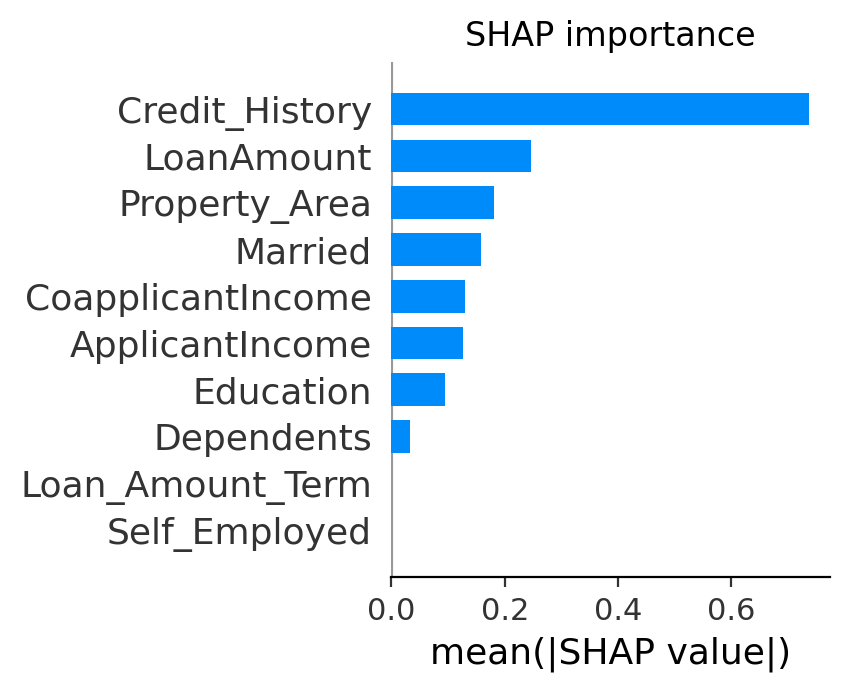

In [4]:
# Import necessary modules
from xbooster import explainer
from xbooster.constructor import XGBScorecardConstructor

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X.loc[ix_train], y.loc[ix_train])
scorecard_constructor.construct_scorecard()
xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Plot Importance
explainer.plot_importance(
    scorecard_constructor,
    metric="Points",
    method="global",
    normalize=True,
    color="#a7fe01",  # type: ignore
    edgecolor="#1e1e1e",  # type: ignore
    figsize=(3, 3),  # type: ignore
)

# SHAP
import shap
from matplotlib import pyplot as plt

shap.initjs()

shap_values = xgb_model.get_booster().predict(
    xgb.DMatrix(X.loc[ix_train], enable_categorical=True), pred_contribs=True
)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X.columns,
    plot_type="bar",
    show=False,
)
plt.title("SHAP importance")
plt.xlabel("mean(|SHAP value|)")
plt.gcf().set_size_inches(3, 3)
plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Using Weight of Evidence</span>

In this approach, we calculate Weight of Evidence (WOE) for each categorical feature.

- WOE contains the log-likelihood of the target variable (loan approval) being 1 or 0 for each category of the feature.
- Therefore the value being output is the weight of evidence in favor of the target variable being 1 or 0.

In [5]:
from optbinning import BinningProcess  # type: ignore
from sklearn.model_selection import train_test_split  # type: ignore
from sklearn.compose import ColumnTransformer  # type: ignore
from sklearn.impute import SimpleImputer  # type: ignore

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)

# WOE
binning_process = BinningProcess(
    variable_names=categorical_features, categorical_variables=categorical_features
)
binning_process.fit(X.loc[ix_train, categorical_features], y[ix_train])
binning_process.transform(X.loc[ix_train])

# Imputer for numerical features
imputer = SimpleImputer(strategy="mean")

transformers = ColumnTransformer(
    [
        # ("imputer", imputer, numerical_features),
        ("categorical", binning_process, categorical_features),
    ],
    remainder="passthrough",
)

column_transformer = ColumnTransformer(transformers, remainder="passthrough")  # type: ignore

# Fit and transform the training data
X_woe_train = pd.DataFrame(
    transformers.fit_transform(X.loc[ix_train], y[ix_train]),  # type: ignore
    columns=features,
    index=ix_train,
)  # type: ignore

# Transform the test data
X_woe_test = pd.DataFrame(transformers.transform(X.loc[ix_test]), columns=features, index=ix_test)  # type: ignore

# Concatenate the transformed training and test data
X_woe = pd.concat([X_woe_train, X_woe_test])

# Clean up unnecessary variables
del X_woe_train, X_woe_test

(CVXPY) Feb 14 12:40:03 PM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Feb 14 12:40:03 PM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.8.3296). Expected < 9.8.0. Please open a feature request on cvxpy to enable support for this version.')


In [18]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.15,
    max_depth=3,
    min_child_weight=15,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Experimental: balanced sample weights
sample_weights = np.ones(len(y.loc[ix_train]))
mask = y.loc[ix_train] == 0
sample_weights[mask] = 1.0
sample_weights[~mask] = 1.0

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)

evalset = [(X_woe.loc[ix_train], y.loc[ix_train]), (X_woe.loc[ix_test], y.loc[ix_test])]

# Fit the XGBoost model
xgb_model.fit(
    X_woe.loc[ix_train],
    y.loc[ix_train],
    sample_weight=sample_weights,
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X_woe.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X_woe.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

Train Gini score: 65.87%
Test Gini score: 65.14%


In [19]:
from xbooster.constructor import XGBScorecardConstructor

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X_woe.loc[ix_train], y.loc[ix_train])

# Construct the scorecard
xgb_scorecard = scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Make predictions using the scorecard
credit_scores = scorecard_constructor.predict_score(X_woe.loc[ix_test])
gini = roc_auc_score(y.loc[ix_test], -credit_scores) * 2 - 1  # type: ignore
print(f"Test Gini score: {gini:.2%}")

Test Gini score: 64.28%


invalid value encountered in scalar divide


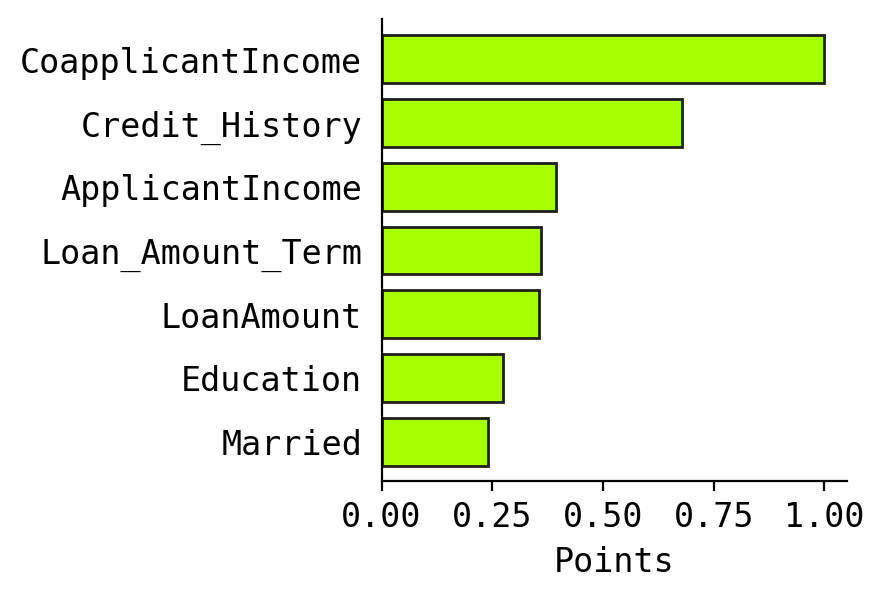

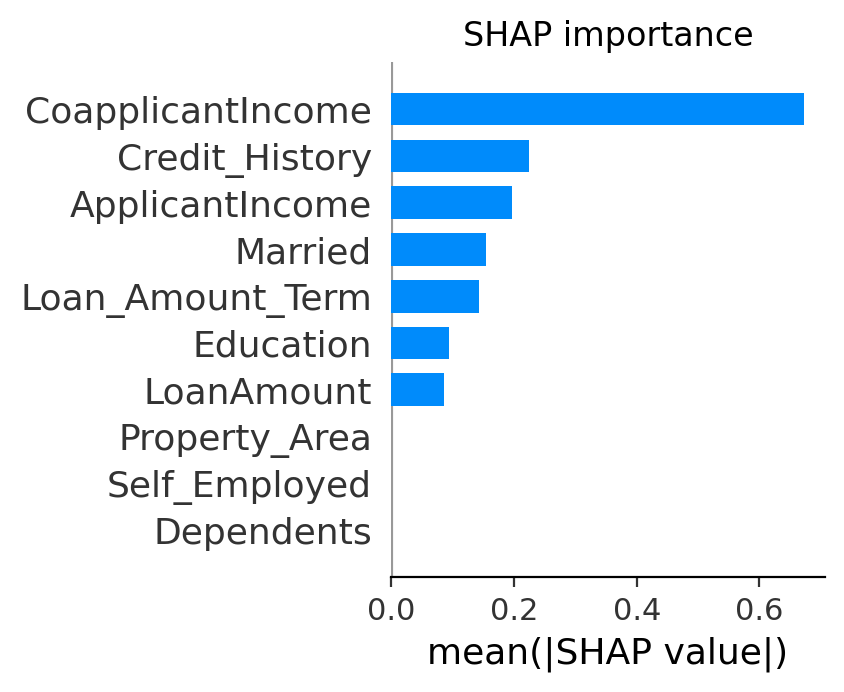

In [20]:
# Import necessary modules
from xbooster import explainer
from xbooster.constructor import XGBScorecardConstructor

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(xgb_model, X_woe.loc[ix_train], y.loc[ix_train])

scorecard_constructor.construct_scorecard()

xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Plot Importance
explainer.plot_importance(
    scorecard_constructor,
    metric="Points",
    method="local",
    normalize=True,
    color="#a7fe01",  # type: ignore
    edgecolor="#1e1e1e",  # type: ignore
    figsize=(3, 3),
)

# SHAP
import shap
from matplotlib import pyplot as plt

shap.initjs()

shap_values = xgb_model.get_booster().predict(xgb.DMatrix(X_woe.loc[ix_train]), pred_contribs=True)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X.columns,
    plot_type="bar",
    # plot_size=[10,5],
    show=False,
)
plt.title("SHAP importance")
plt.xlabel("mean(|SHAP value|)")
plt.gcf().set_size_inches(3, 3)
plt.show()

<span style="font-family: Virgil GS, sans-serif; color: navyblue; font-size: 25px;">Using One Hot Encoding</span>

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
import pandas as pd

X, y = dataset[features], dataset[target]

ix_train, ix_test = train_test_split(X.index, stratify=y, test_size=0.3, random_state=62)


# Define a function to strip spaces from string values (spaces will cause issues)
def remove_spaces(X):
    """
    Remover of spaces from string values

    Args:
    X : pd.DataFrame
        Input DataFrame

    Returns:
    pd.DataFrame
        DataFrame with spaces removed from string values
    """
    return X.applymap(lambda x: x.strip().replace(" ", "") if isinstance(x, str) else x)


ohe_encoder = OneHotEncoder(
    handle_unknown="ignore", drop="first", dtype=int, sparse_output=False
).set_output(transform="pandas")

# Define a pipeline for preprocessing categorical features
categorical_pipeline = Pipeline(
    [
        ("strip_spaces", FunctionTransformer(remove_spaces, validate=False)),
        ("ohe", ohe_encoder),
    ]
)

# Define a column transformer for applying preprocessing to categorical features
preprocessor = ColumnTransformer(
    transformers=[("categorical", categorical_pipeline, categorical_features)],
    remainder="passthrough",
)

# # Fit and transform the preprocessor on the training data
preprocessor.fit(X.loc[ix_train])
categorical_features_ohe = (
    preprocessor.named_transformers_["categorical"]
    .named_steps["ohe"]
    .get_feature_names_out(categorical_features)
)
column_names = list(categorical_features_ohe) + numerical_features

X_ohe_train = pd.DataFrame(
    preprocessor.transform(X.loc[ix_train]), columns=column_names, index=ix_train  # type: ignore
)  # type: ignore
X_ohe_test = pd.DataFrame(
    preprocessor.transform(X.loc[ix_test]), columns=column_names, index=ix_test  # type: ignore
)  # type: ignore

X_ohe = pd.concat([X_ohe_train, X_ohe_test])

# Clean up unnecessary variables
del X_ohe_train, X_ohe_test

In [58]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score

best_params = dict(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=3,
    min_child_weight=15,
    grow_policy="lossguide",
    early_stopping_rounds=5,
)

# Experimental: balanced sample weights
sample_weights = np.ones(len(y.loc[ix_train]))
mask = y.loc[ix_train] == 0
sample_weights[mask] = 1.0
sample_weights[~mask] = 1.0

# Create an XGBoost model
xgb_model = xgb.XGBClassifier(**best_params, random_state=62)

evalset = [(X_ohe.loc[ix_train], y.loc[ix_train]), (X_ohe.loc[ix_test], y.loc[ix_test])]

# Fit the XGBoost model
xgb_model.fit(
    X_ohe.loc[ix_train],
    y.loc[ix_train],
    sample_weight=sample_weights,
    eval_set=evalset,
    verbose=False,
)

# Make predictions using the model
predictions_trn = xgb_model.predict_proba(X_ohe.loc[ix_train])[:, 1]
predictions_tst = xgb_model.predict_proba(X_ohe.loc[ix_test])[:, 1]

# Calculate the Gini score
gini_trn = roc_auc_score(y.loc[ix_train], predictions_trn) * 2 - 1  # type: ignore
gini_tst = roc_auc_score(y.loc[ix_test], predictions_tst) * 2 - 1  # type: ignore

print(f"Train Gini score: {gini_trn:.2%}\n" f"Test Gini score: {gini_tst:.2%}")

Train Gini score: 59.66%
Test Gini score: 57.60%


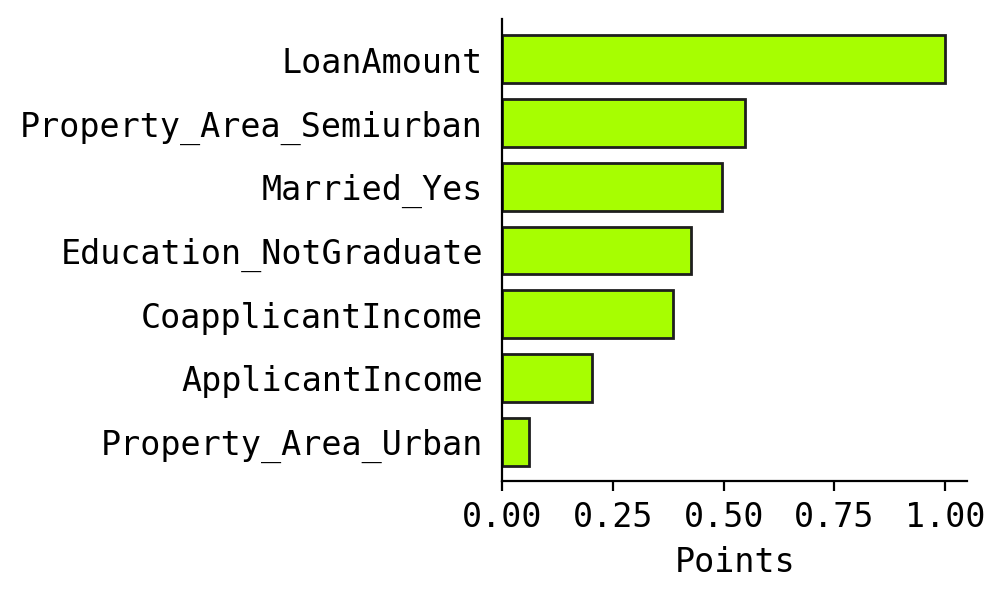

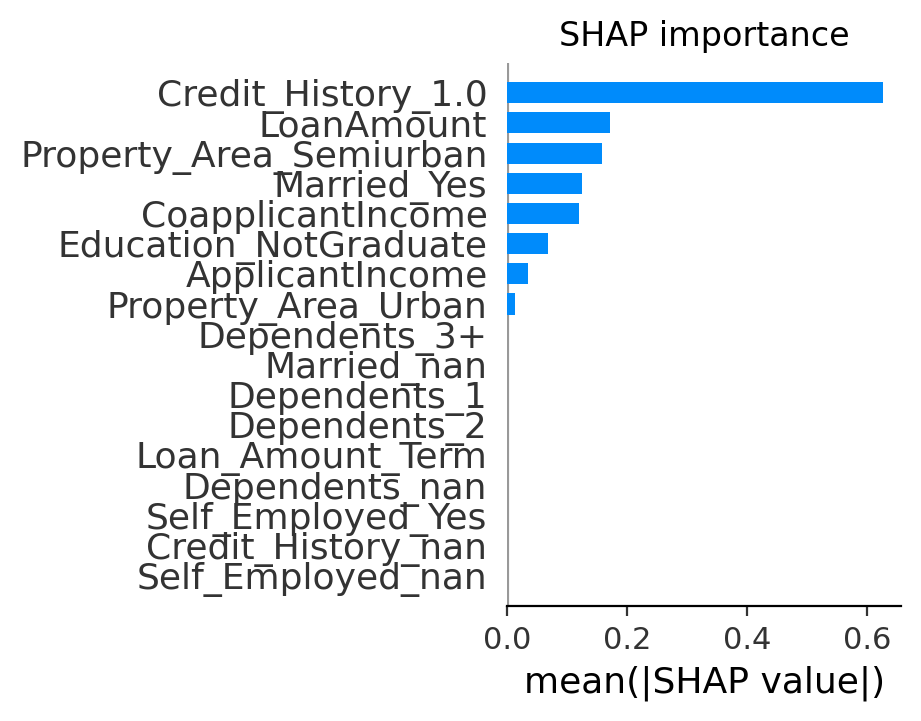

In [62]:
# Import necessary modules
from xbooster import explainer
from xbooster.constructor import XGBScorecardConstructor

%config InlineBackend.figure_format = 'retina'

# Set up the scorecard constructor
scorecard_constructor = XGBScorecardConstructor(
    xgb_model,
    X_ohe.loc[ix_train],
    y.loc[ix_train],
)
scorecard_constructor.construct_scorecard()
xgb_scorecard_with_points = scorecard_constructor.create_points(
    pdo=50, target_points=600, target_odds=50
)

# Plot Importance
explainer.plot_importance(
    scorecard_constructor,
    metric="Points",
    method="local",
    normalize=True,
    color="#a7fe01",  # type: ignore
    edgecolor="#1e1e1e",  # type: ignore
    figsize=(3, 3),  # type: ignore
)

# SHAP
import shap
from matplotlib import pyplot as plt

shap.initjs()

shap_values = xgb_model.get_booster().predict(xgb.DMatrix(X_ohe.loc[ix_train]), pred_contribs=True)

fig = plt.figure(dpi=100)
shap.summary_plot(
    shap_values[:, :-1],
    feature_names=X_ohe.columns,
    plot_type="bar",
    show=False,
)
plt.title("SHAP importance")
plt.xlabel("mean(|SHAP value|)")
plt.gcf().set_size_inches(3, 3)
plt.show()